<a href="https://colab.research.google.com/github/kevineladio/TELLER/blob/master/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Con este modelo buscamos predecir el tipo de recalada que tendra el barco en el mundo, puede ser de tipo in transit o debark, dependiendo a esto, el modelo debe ser capaz de identificar el tipo de call en ada uno de los puertos con las lineas de crucero correspondientes.

### **1. Analisis exploratorio de los datos**

In [1]:
#Analisis exploratorio de los datos.

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans

In [3]:
df = pd.read_excel('/content/compiled.xlsx')
df.head()

,Day counts,Year,Date,Region,Country,Location,Line,Ship,ETA,ETD,Type
0,1.0,2023,2023-05-01,Caribbean,Mexico,Cozumel,Carnival,Carnival Breeze,0.375000,0.708333,In transit
1,1.0,2023,2023-05-01,Caribbean,Mexico,Cozumel,Carnival,Carnival Mardi Gras,0.416667,0.791667,In transit
2,1.0,2023,2023-05-01,Caribbean,Curaçao,Willemstad,Celebrity,Celebrity Summit,0.333333,0.833333,In transit
3,1.0,2023,2023-05-01,Caribbean,Saint Kitts and Nevis,Basseterre,Celebrity,Celebrity Equinox,0.291667,0.708333,In transit
4,1.0,2023,2023-05-01,Mediterranean,Spain,Barcelona,Celebrity,Celebrity Edge,0.208333,0.708333,Debark/Embark


In [4]:
df.shape #identificamos las filas y columnas de nuestro archivo CSV.

(47680, 11)

In [5]:
df.duplicated().sum() # Verificamos si hay columnas duplicados

0

In [6]:
df.isna().sum() # Identificamos si hay valores faltantes

Day counts      0
Year            0
Date            0
Region        737
Country         0
Location        0
Line            0
Ship            0
ETA             0
ETD             0
Type            0
dtype: int64

In [7]:
df['Region'].fillna('Missing', inplace=True) #ponemos los valores faltantes en NA como Missing

In [8]:
df.isna().sum() #Validamos nuevamente que no falte ningun valor 

Day counts    0
Year          0
Date          0
Region        0
Country       0
Location      0
Line          0
Ship          0
ETA           0
ETD           0
Type          0
dtype: int64

In [9]:
#La columna Day count es irrelevante debido a que solo es un contador de dias puesto en excel 
# para observar las proximas recaladas
df = df.drop(columns = 'Day counts')

Verificamos que los datos pertenezcan a los tipos descritos en el diccionario de datos. 

In [10]:
df.dtypes  #Sacado de "https://datacarpentry.org/python-ecology-lesson-es/02-starting-with-data/"
df.info() #Tambien se puede usar esta instruccion para obtener mas informacion 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47680 entries, 0 to 47679
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Year      47680 non-null  int64         
 1   Date      47680 non-null  datetime64[ns]
 2   Region    47680 non-null  object        
 3   Country   47680 non-null  object        
 4   Location  47680 non-null  object        
 5   Line      47680 non-null  object        
 6   Ship      47680 non-null  object        
 7   ETA       47680 non-null  float64       
 8   ETD       47680 non-null  float64       
 9   Type      47680 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 3.6+ MB


In [11]:
#Informacion a tener en cuenta 

# - Todas las columas tienen el mismo largo de filas
# - Hay mas datos de tipo obsejto, por lo que sea probable que se realice un OHE. 

Como el objetivo del modelo es predecir que tipo de recalada es, se usara la columna Type como el el target

In [12]:
df['Type'].replace({'In transit':0, 'Debark/Embark':1}, inplace=True) 
df['Type'].value_counts()

0    37238
1    10442
Name: Type, dtype: int64

In [13]:
df.head() 

,Year,Date,Region,Country,Location,Line,Ship,ETA,ETD,Type
0,2023,2023-05-01,Caribbean,Mexico,Cozumel,Carnival,Carnival Breeze,0.375000,0.708333,0
1,2023,2023-05-01,Caribbean,Mexico,Cozumel,Carnival,Carnival Mardi Gras,0.416667,0.791667,0
2,2023,2023-05-01,Caribbean,Curaçao,Willemstad,Celebrity,Celebrity Summit,0.333333,0.833333,0
3,2023,2023-05-01,Caribbean,Saint Kitts and Nevis,Basseterre,Celebrity,Celebrity Equinox,0.291667,0.708333,0
4,2023,2023-05-01,Mediterranean,Spain,Barcelona,Celebrity,Celebrity Edge,0.208333,0.708333,1


In [14]:
# Con ayuda del paquete pandas, podemos sacar mas informacion que nos puede ser de utilidad
# Como es el caso de dia y el mes del año, por medio de la ingenieria de datos. 

#Conevrtimos la columna Date en un tipo date_time
df['Date'] = pd.to_datetime(df['Date'])
#
df['month (name)'] = df['Date'].dt.month_name()
df['day of week (name)'] = df['Date'].dt.day_name()

In [15]:
df.head(80) #Evaluamos que se hayan realizado los cambios

,Year,Date,Region,Country,Location,Line,Ship,ETA,ETD,Type,month (name),day of week (name)
0,2023,2023-05-01,Caribbean,Mexico,Cozumel,Carnival,Carnival Breeze,0.375000,0.708333,0,May,Monday
1,2023,2023-05-01,Caribbean,Mexico,Cozumel,Carnival,Carnival Mardi Gras,0.416667,0.791667,0,May,Monday
2,2023,2023-05-01,Caribbean,Curaçao,Willemstad,Celebrity,Celebrity Summit,0.333333,0.833333,0,May,Monday
3,2023,2023-05-01,Caribbean,Saint Kitts and Nevis,Basseterre,Celebrity,Celebrity Equinox,0.291667,0.708333,0,May,Monday
4,2023,2023-05-01,Mediterranean,Spain,Barcelona,Celebrity,Celebrity Edge,0.208333,0.708333,1,May,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2023,2023-05-01,Mediterranean,Montenegro,Kotor,RSSC,MS Seven Seas Voyager,45047.458330,45047.791670,0,May,Monday
76,2023,2023-05-02,Caribbean,Bahamas,Nassau,Carnival,Carnival Sunshine,0.333333,0.708333,0,May,Tuesday
77,2023,2023-05-02,Caribbean,Bahamas,Nassau,Carnival,Carnival Liberty,0.416667,0.750000,0,May,Tuesday
78,2023,2023-05-02,Mediterranean,France,Le Havre,Celebrity,Celebrity Silhouette,0.291667,0.916667,0,May,Tuesday


In [94]:
df['Date'] = pd.to_numeric(pd.to_datetime(df['Date']))

Por medio de una vista rapida con un tipo de grafico, podmeos sacar algunas conclusiones de nuestro data set.

<ipython-input-16-cb7f2108d40e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


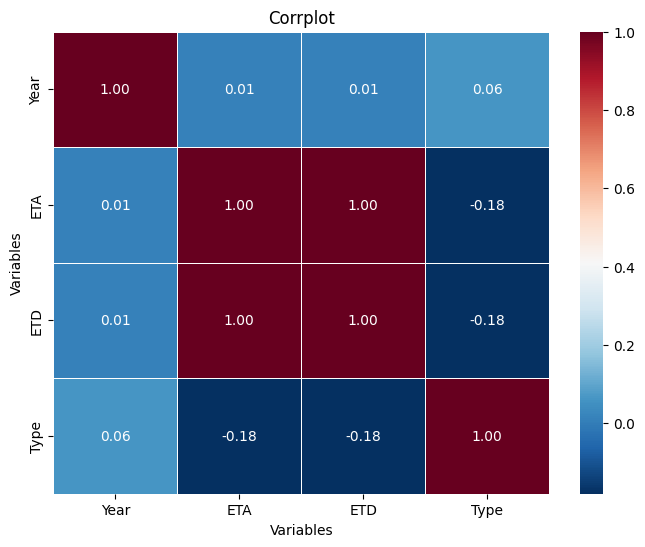

In [16]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Crear el correlograma con heatmap y anotaciones
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="RdBu_r", linewidths=0.5)

# Personalizar el título y los ejes
plt.title("Corrplot")
plt.xlabel("Variables")
plt.ylabel("Variables")

# Mostrar el correlograma
plt.show()

In [17]:
# Las variables de tipo "tiempo" se relacionan muy bien entre ellas incluso con nuestra columna objetivo que seria el type
# esto es un indicador que nuestro modelo puede tener una alta precicion si solo se trabajan con los valores de tipo int y float
# Sin embargo es importante resaltar que en estos casos tambien se hace importante el barco, la linea de crucero y el puerto (nuestras variables string)

De nuestra columna objetivo es importante ver la division entre un estado y el otro. (In transit = 0 / Debark = 1)

Text(0, 0.5, 'cantidad de recaladas')

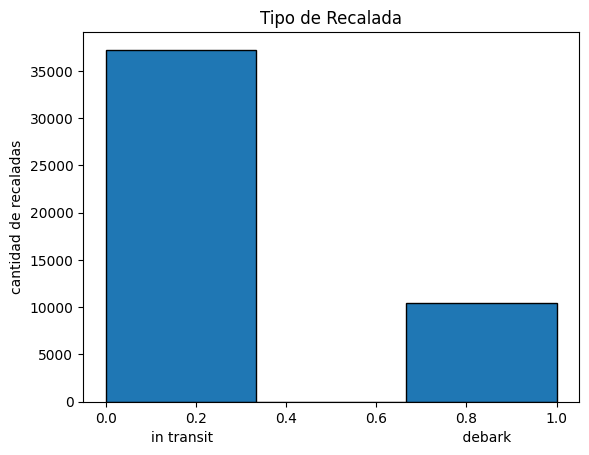

In [18]:
# Crear el histograma
plt.hist(df['Type'], bins=3, edgecolor='black')

# Personalizar el histograma
plt.title('Tipo de Recalada')
plt.xlabel('in transit                                                         debark')
plt.ylabel('cantidad de recaladas')

La diferencia entre las recaladas tipo in transit = 0 y debark = 1 es muy marcada, esto tiene sentido si tomamos en cuenta que en una navegacion comun, hay solo 2 puertos o dos recaladas tipo debark, mientras que el resto es in transit.

## **2. Procesamiento de datos, modelado e hiperparametros**

In [19]:
# Usamos One hot Encoder para transformar los datos de Variables objetos a variables numericas. 

In [21]:
X = df.drop(columns = 'Type')
y = df['Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [22]:
# hagan un selector categórico
cat_selector = make_column_selector(dtype_include='object')

In [23]:
cat_selector(X_train)

['Region',
 'Country',
 'Location',
 'Line',
 'Ship',
 'month (name)',
 'day of week (name)']

In [24]:
# creen un subconjunto de datos solo para las columnas categóricas
train_cat_data = X_train[cat_selector(X_train)]
test_cat_data = X_test[cat_selector(X_test)]
train_cat_data

,Region,Country,Location,Line,Ship,month (name),day of week (name)
39161,Missing,Passage,Hubbard Glacier (Cruising),Royal,Radiance of the Seas,September,Saturday
15211,North America,United States of America,Cape Liberty,Royal,Liberty of the Seas,October,Thursday
35209,North America,United States of America,Miami,Royal,Allure of the Seas,July,Friday
11658,Northern Europe,England,Southampton,RSSC,MS Seven Seas Voyager,September,Thursday
38921,North America,United States of America,Hubbard Glacier,Norwegian,Norwegian Jewel,September,Tuesday
...,...,...,...,...,...,...,...
11284,Mediterranean,Spain,Cadiz,Norwegian,Norwegian Gem,September,Sunday
44732,Caribbean,Haiti,Labadee,Royal,Adventure of the Seas,December,Monday
38158,North America,Canada,Victoria,Norwegian,Norwegian Bliss,August,Friday
860,North America,Alaska,Ketchikan,Norwegian,Norwegian Bliss,May,Thursday


In [25]:
# instancien la codificación one-hot
ohe_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# ajusten el OneHotEncoder en los datos de entrenamiento
ohe_encoder.fit(train_cat_data)
# transforme los datos de entrenamiento y de prueba
train_ohe = ohe_encoder.transform(train_cat_data)
test_ohe = ohe_encoder.transform(test_cat_data)
train_ohe

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [26]:
ohe_column_names = ohe_encoder.get_feature_names_out(train_cat_data.columns)
train_ohe = pd.DataFrame(train_ohe, columns=ohe_column_names)
test_ohe = pd.DataFrame(test_ohe, columns=ohe_column_names)
train_ohe

,Region_Africa,Region_Antarctica,Region_Asia,Region_Caribbean,Region_Mediterranean,Region_Middle East,Region_Missing,Region_North America,Region_Northern Europe,Region_Oceania,...,month (name)_November,month (name)_October,month (name)_September,day of week (name)_Friday,day of week (name)_Monday,day of week (name)_Saturday,day of week (name)_Sunday,day of week (name)_Thursday,day of week (name)_Tuesday,day of week (name)_Wednesday
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35755,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
35756,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
35758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [27]:
# creen un selector numérico
num_selector = make_column_selector(dtype_include='number')
# aislen las columnas numéricas
train_nums = X_train[num_selector(X_train)].reset_index(drop=True)
test_nums = X_test[num_selector(X_test)].reset_index(drop=True)
# recombinen los conjuntos de entrenamiento y de prueba en el eje 1 (columnas)
X_train_processed = pd.concat([train_nums, train_ohe], axis=1)
X_test_processed = pd.concat([test_nums, test_ohe], axis=1)
X_train_processed

,Year,ETA,ETD,Region_Africa,Region_Antarctica,Region_Asia,Region_Caribbean,Region_Mediterranean,Region_Middle East,Region_Missing,...,month (name)_November,month (name)_October,month (name)_September,day of week (name)_Friday,day of week (name)_Monday,day of week (name)_Saturday,day of week (name)_Sunday,day of week (name)_Thursday,day of week (name)_Tuesday,day of week (name)_Wednesday
0,2024,0.583333,0.708333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2023,0.291667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2024,0.000000,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,45176.291670,45176.708330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2024,45545.583330,45545.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35755,2023,45172.291670,45172.708330,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
35756,2024,0.291667,0.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35757,2024,45534.833330,45534.999310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
35758,2023,45057.270830,45057.552080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
# para efectos de practicidad en cuanto al codigo, igualaremos los train y test a un nombre mas estandar para la codificacion
X_test = X_test_processed 
X_train = X_train_processed

In [29]:
# instancien el escalador
scaler = StandardScaler()
# ajusten el escalador en los datos de entrenamiento
scaler.fit(X_train)

StandardScaler()

In [30]:
# transformen los datos de entrenamiento
train_scaled = scaler.transform(X_train)
# transformen los datos de prueba
test_scaled = scaler.transform(X_test)
# observen las 5 primeras filas de train_scaled
train_scaled[:5]

array([[ 0.66576498, -0.78142603, -0.78138546, ..., -0.40153141,
        -0.40026271, -0.4043912 ],
       [-1.04051723, -0.78143929, -0.78141765, ...,  2.4904652 ,
        -0.40026271, -0.4043912 ],
       [ 0.66576498, -0.78145254, -0.78138735, ..., -0.40153141,
        -0.40026271, -0.4043912 ],
       [-1.04051723,  1.27144031,  1.27151907, ...,  2.4904652 ,
        -0.40026271, -0.4043912 ],
       [ 0.66576498,  1.2882216 ,  1.28828919, ..., -0.40153141,
         2.49835912, -0.4043912 ]])

In [31]:
# transformen de nuevo a un DataFrame
X_train_scaled = pd.DataFrame(train_scaled, columns=X_train.columns)
X_train_scaled.head()

,Year,ETA,ETD,Region_Africa,Region_Antarctica,Region_Asia,Region_Caribbean,Region_Mediterranean,Region_Middle East,Region_Missing,...,month (name)_November,month (name)_October,month (name)_September,day of week (name)_Friday,day of week (name)_Monday,day of week (name)_Saturday,day of week (name)_Sunday,day of week (name)_Thursday,day of week (name)_Tuesday,day of week (name)_Wednesday
0,0.665765,-0.781426,-0.781385,-0.086076,-0.029456,-0.224236,-0.529172,-0.486767,-0.07975,8.038326,...,-0.29891,-0.320123,3.021166,-0.407196,-0.421649,2.436311,-0.412083,-0.401531,-0.400263,-0.404391
1,-1.040517,-0.781439,-0.781418,-0.086076,-0.029456,-0.224236,-0.529172,-0.486767,-0.07975,-0.124404,...,-0.29891,3.123799,-0.330998,-0.407196,-0.421649,-0.410457,-0.412083,2.490465,-0.400263,-0.404391
2,0.665765,-0.781453,-0.781387,-0.086076,-0.029456,-0.224236,-0.529172,-0.486767,-0.07975,-0.124404,...,-0.29891,-0.320123,-0.330998,2.455823,-0.421649,-0.410457,-0.412083,-0.401531,-0.400263,-0.404391
3,-1.040517,1.271440,1.271519,-0.086076,-0.029456,-0.224236,-0.529172,-0.486767,-0.07975,-0.124404,...,-0.29891,-0.320123,3.021166,-0.407196,-0.421649,-0.410457,-0.412083,2.490465,-0.400263,-0.404391
4,0.665765,1.288222,1.288289,-0.086076,-0.029456,-0.224236,-0.529172,-0.486767,-0.07975,-0.124404,...,-0.29891,-0.320123,3.021166,-0.407196,-0.421649,-0.410457,-0.412083,-0.401531,2.498359,-0.404391


In [32]:
X_train_scaled.shape

(35760, 1319)

In [33]:
X_train_scaled.describe().round(2)

,Year,ETA,ETD,Region_Africa,Region_Antarctica,Region_Asia,Region_Caribbean,Region_Mediterranean,Region_Middle East,Region_Missing,...,month (name)_November,month (name)_October,month (name)_September,day of week (name)_Friday,day of week (name)_Monday,day of week (name)_Saturday,day of week (name)_Sunday,day of week (name)_Thursday,day of week (name)_Tuesday,day of week (name)_Wednesday
count,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,...,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.0,35760.00
mean,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.0,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00
min,-1.04,-0.78,-0.78,-0.09,-0.03,-0.22,-0.53,-0.49,-0.08,-0.12,...,-0.30,-0.32,-0.33,-0.41,-0.42,-0.41,-0.41,-0.40,-0.4,-0.40
25%,-1.04,-0.78,-0.78,-0.09,-0.03,-0.22,-0.53,-0.49,-0.08,-0.12,...,-0.30,-0.32,-0.33,-0.41,-0.42,-0.41,-0.41,-0.40,-0.4,-0.40
50%,0.67,-0.78,-0.78,-0.09,-0.03,-0.22,-0.53,-0.49,-0.08,-0.12,...,-0.30,-0.32,-0.33,-0.41,-0.42,-0.41,-0.41,-0.40,-0.4,-0.40
75%,0.67,1.27,1.27,-0.09,-0.03,-0.22,-0.53,-0.49,-0.08,-0.12,...,-0.30,-0.32,-0.33,-0.41,-0.42,-0.41,-0.41,-0.40,-0.4,-0.40
max,2.37,1.30,1.30,11.62,33.95,4.46,1.89,2.05,12.54,8.04,...,3.35,3.12,3.02,2.46,2.37,2.44,2.43,2.49,2.5,2.47


In [34]:
x_test_scaled = pd.DataFrame (test_scaled, columns = X_test.columns)
x_test_scaled.head()

,Year,ETA,ETD,Region_Africa,Region_Antarctica,Region_Asia,Region_Caribbean,Region_Mediterranean,Region_Middle East,Region_Missing,...,month (name)_November,month (name)_October,month (name)_September,day of week (name)_Friday,day of week (name)_Monday,day of week (name)_Saturday,day of week (name)_Sunday,day of week (name)_Thursday,day of week (name)_Tuesday,day of week (name)_Wednesday
0,0.665765,1.288468,1.288552,-0.086076,-0.029456,-0.224236,-0.529172,2.054370,-0.07975,-0.124404,...,-0.29891,-0.320123,3.021166,-0.407196,2.371640,-0.410457,-0.412083,-0.401531,-0.400263,-0.404391
1,0.665765,1.284208,1.284294,-0.086076,-0.029456,-0.224236,-0.529172,2.054370,-0.07975,-0.124404,...,-0.29891,-0.320123,-0.330998,2.455823,-0.421649,-0.410457,-0.412083,-0.401531,-0.400263,-0.404391
2,0.665765,-0.781436,-0.781387,-0.086076,-0.029456,-0.224236,-0.529172,-0.486767,-0.07975,-0.124404,...,-0.29891,-0.320123,-0.330998,2.455823,-0.421649,-0.410457,-0.412083,-0.401531,-0.400263,-0.404391
3,-1.040517,1.275532,1.275613,-0.086076,-0.029456,-0.224236,1.889745,-0.486767,-0.07975,-0.124404,...,-0.29891,-0.320123,-0.330998,-0.407196,-0.421649,-0.410457,-0.412083,-0.401531,-0.400263,2.472853
4,0.665765,-0.781437,-0.781384,-0.086076,-0.029456,-0.224236,1.889745,-0.486767,-0.07975,-0.124404,...,-0.29891,-0.320123,-0.330998,-0.407196,-0.421649,2.436311,-0.412083,-0.401531,-0.400263,-0.404391


In [35]:
X_train_scaled.describe().round(2)

,Year,ETA,ETD,Region_Africa,Region_Antarctica,Region_Asia,Region_Caribbean,Region_Mediterranean,Region_Middle East,Region_Missing,...,month (name)_November,month (name)_October,month (name)_September,day of week (name)_Friday,day of week (name)_Monday,day of week (name)_Saturday,day of week (name)_Sunday,day of week (name)_Thursday,day of week (name)_Tuesday,day of week (name)_Wednesday
count,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,...,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.00,35760.0,35760.00
mean,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.0,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00
min,-1.04,-0.78,-0.78,-0.09,-0.03,-0.22,-0.53,-0.49,-0.08,-0.12,...,-0.30,-0.32,-0.33,-0.41,-0.42,-0.41,-0.41,-0.40,-0.4,-0.40
25%,-1.04,-0.78,-0.78,-0.09,-0.03,-0.22,-0.53,-0.49,-0.08,-0.12,...,-0.30,-0.32,-0.33,-0.41,-0.42,-0.41,-0.41,-0.40,-0.4,-0.40
50%,0.67,-0.78,-0.78,-0.09,-0.03,-0.22,-0.53,-0.49,-0.08,-0.12,...,-0.30,-0.32,-0.33,-0.41,-0.42,-0.41,-0.41,-0.40,-0.4,-0.40
75%,0.67,1.27,1.27,-0.09,-0.03,-0.22,-0.53,-0.49,-0.08,-0.12,...,-0.30,-0.32,-0.33,-0.41,-0.42,-0.41,-0.41,-0.40,-0.4,-0.40
max,2.37,1.30,1.30,11.62,33.95,4.46,1.89,2.05,12.54,8.04,...,3.35,3.12,3.02,2.46,2.37,2.44,2.43,2.49,2.5,2.47


In [36]:
df['Type'].value_counts(normalize = True)

0    0.780998
1    0.219002
Name: Type, dtype: float64

# Decision Tree

In [37]:
dec_tree = DecisionTreeClassifier(random_state = 42, max_depth=2)

In [38]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [39]:
dec_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [40]:
dec_tree.predict(x_test_scaled)

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
train_score = dec_tree.score(X_train_scaled, y_train)
test_score = dec_tree.score(x_test_scaled, y_test)
print(train_score)
print(test_score)

0.8694910514541387
0.8702181208053691


In [42]:
dec_tree.get_depth()

2

In [43]:
max_depth_range_dc = list(range(2, 16))# evaluamos entre 2 y 16

r2_dc = []#Lista para almacenar la puntuación para cada valor de max_depth:
for depth in max_depth_range_dc:
    descision_tree_regrecion = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 42)
    descision_tree_regrecion.fit(X_train_scaled, y_train)
    score = descision_tree_regrecion.score(x_test_scaled, y_test)
    r2_dc.append(score)

#Buscamos el r2 mas alto
for i in range(len(r2_dc)):
    if (r2_dc[i]==max(r2_dc)):
        break
print("profundidad ",max_depth_range_dc[i])

profundidad  15


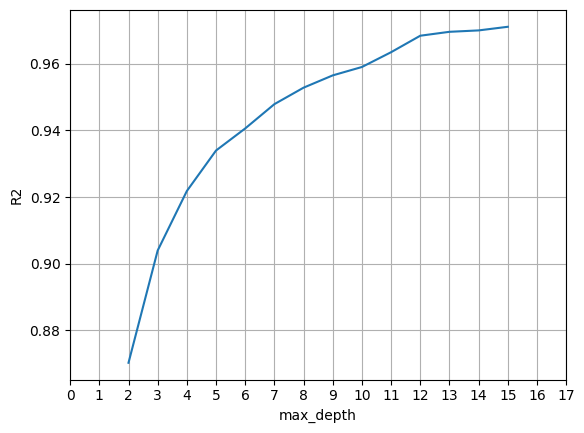

In [44]:
#Observar cual seria la mejor profundidad para el modelo

plt.plot(max_depth_range_dc, r2_dc)
plt.xlabel('max_depth')
plt.xticks(np.arange(0, 18, 1))
plt.grid(True)
plt.ylabel('R2');

In [45]:
#Evaluamos con profundidad 15
dec_tree_15 = DecisionTreeClassifier(max_depth= 15, random_state= 42)
dec_tree_15.fit(X_train_scaled, y_train)

y_predict_15 = dec_tree_15.predict(x_test_scaled)

dec_tree_r2_train_15 = dec_tree_15.score(X_train_scaled, y_train)
dec_tree_r2_test_15 = dec_tree_15.score(x_test_scaled, y_test)

print(dec_tree_r2_train_15)
print(dec_tree_r2_test_15)

0.9767337807606264
0.9711409395973154


Modelo de clasificacion: 0.9056240369799692
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9324
           1       0.96      0.91      0.93      2596

    accuracy                           0.97     11920
   macro avg       0.97      0.95      0.96     11920
weighted avg       0.97      0.97      0.97     11920



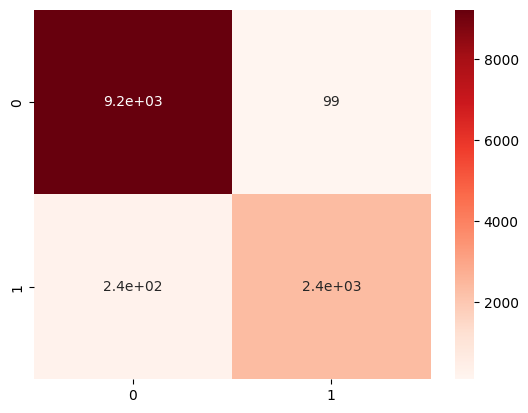

In [46]:
#Matriz de confucion 

cm = confusion_matrix(y_test, y_predict_15)
sns.heatmap(cm,annot= True, cmap = "Reds")

dec_tree_recall = recall_score(y_test, y_predict_15)

print("Modelo de clasificacion:", dec_tree_recall)


class_report_test = classification_report(y_test, y_predict_15)
print(class_report_test)

# **KNN**

In [47]:
scaler = StandardScaler()

In [48]:
knn = KNeighborsClassifier(n_neighbors=1)

In [49]:
# Ver la cantidad de hiperparametros
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [50]:
knn_pipe = make_pipeline(scaler, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

In [51]:
predictions = knn_pipe.predict(X_test)
predictions

array([0, 1, 0, ..., 0, 0, 0])

In [52]:
# calculen la exactitud de la clasificación
acc_score = knn_pipe.score(X_test, y_test)
acc_score

0.9712248322147651

Realizamos una curva ROC

In [53]:
logreg = LogisticRegression(C = .001)
scaler = StandardScaler()
# Creamos un pipeline
logreg_pipe = make_pipeline(scaler, logreg)
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.001))])

In [56]:
print(f'Training AUC: {roc_auc_score(y_train, logreg_pipe.predict_proba(X_train)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, logreg_pipe.predict_proba(X_test)[:,1])}')

Training AUC: 0.9922039189556957
Testing AUC: 0.990879712807679


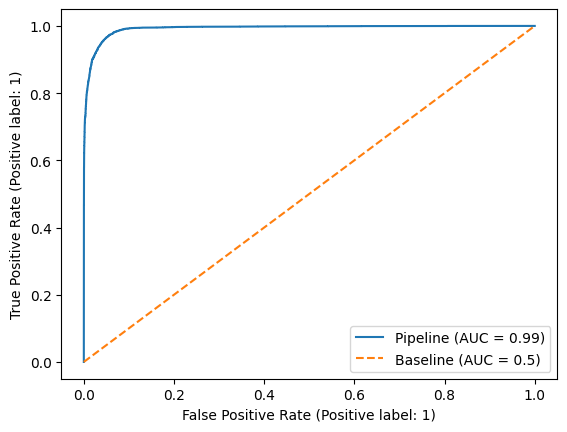

In [57]:
# Vizual de la curva ROC 
RocCurveDisplay.from_estimator(logreg_pipe, X_train, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

# **Redes Neuronales**

In [81]:
#usamos esta sentencia para saber el numero de neuronas que podemos utilizar
input_shape = X_train.shape[1]
input_shape

1319

In [83]:
model = Sequential()

model.add(Dense(19, 
                input_dim = input_shape, 
                activation = 'relu'))
model.add(Dense(9, 
                activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'bce', optimizer = 'adam')
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=100)

Epoch 1/100
1118/1118 [==============================] - 4s 3ms/step - loss: 6.0300 - val_loss: 0.5814
Epoch 2/100
1118/1118 [==============================] - 3s 3ms/step - loss: 3.5195 - val_loss: 5.2517
Epoch 3/100
1118/1118 [==============================] - 3s 3ms/step - loss: 2.4698 - val_loss: 5.0427
Epoch 4/100
1118/1118 [==============================] - 4s 3ms/step - loss: 2.4119 - val_loss: 0.7050
Epoch 5/100
1118/1118 [==============================] - 3s 3ms/step - loss: 2.1576 - val_loss: 2.9731
Epoch 6/100
1118/1118 [==============================] - 3s 3ms/step - loss: 1.4704 - val_loss: 1.4887
Epoch 7/100
1118/1118 [==============================] - 3s 2ms/step - loss: 0.9648 - val_loss: 0.5531
Epoch 8/100
1118/1118 [==============================] - 4s 3ms/step - loss: 0.9484 - val_loss: 0.6112
Epoch 9/100
1118/1118 [==============================] - 3s 2ms/step - loss: 0.5108 - val_loss: 0.4933
Epoch 10/100
1118/1118 [==============================] - 3s 3ms/step - l

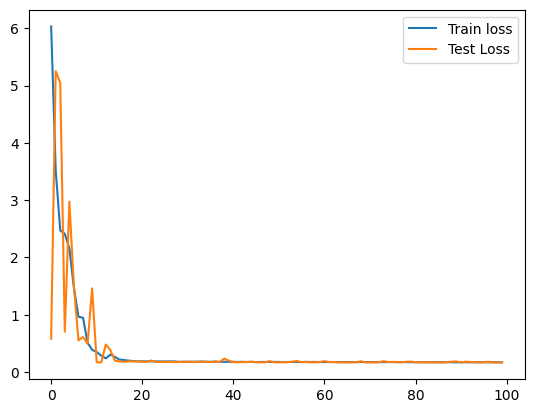

In [84]:
# Visual de la perdida
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [86]:
model = Sequential()
model.add(Dense(19,
                input_dim = input_shape,
                activation = 'relu'))
model.add(Dense(9, 
                activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'bce', optimizer = 'adam')
early_stopping = EarlyStopping(patience = 5)
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=100,
                    callbacks = [early_stopping])

Epoch 1/100
1118/1118 [==============================] - 5s 3ms/step - loss: 8.3023 - val_loss: 8.5808
Epoch 2/100
1118/1118 [==============================] - 3s 3ms/step - loss: 4.4824 - val_loss: 2.6163
Epoch 3/100
1118/1118 [==============================] - 3s 3ms/step - loss: 3.7290 - val_loss: 6.2163
Epoch 4/100
1118/1118 [==============================] - 4s 4ms/step - loss: 2.7418 - val_loss: 4.7116
Epoch 5/100
1118/1118 [==============================] - 4s 4ms/step - loss: 3.1842 - val_loss: 3.9130
Epoch 6/100
1118/1118 [==============================] - 4s 4ms/step - loss: 1.9661 - val_loss: 0.1941
Epoch 7/100
1118/1118 [==============================] - 5s 4ms/step - loss: 1.1869 - val_loss: 1.0901
Epoch 8/100
1118/1118 [==============================] - 5s 4ms/step - loss: 1.0883 - val_loss: 1.3830
Epoch 9/100
1118/1118 [==============================] - 4s 4ms/step - loss: 0.6821 - val_loss: 0.2047
Epoch 10/100
1118/1118 [==============================] - 3s 3ms/step - l

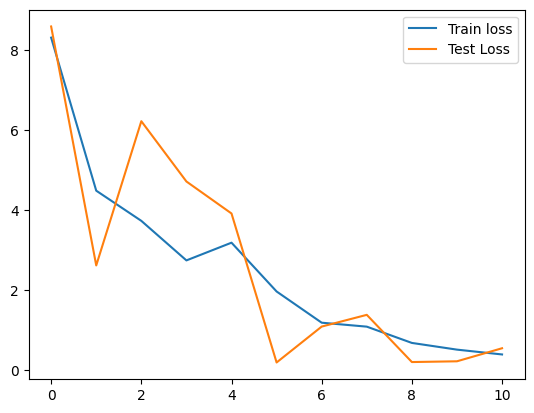

In [87]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [88]:
loss = model.evaluate(X_test, y_test)
loss

373/373 [==============================] - 1s 3ms/step - loss: 0.5492


0.5491582751274109

In [90]:
y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_rounded)

accuracy

373/373 [==============================] - 1s 2ms/step


0.6537751677852349

In [ ]:
#metodo del codo para el analisis pca reduccion de la dimensionalidad

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

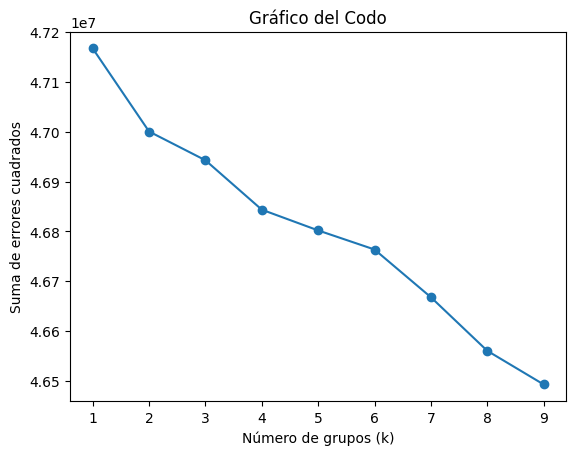

In [96]:
sse = [] # Suma de errores cuadrados

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_train_scaled)
    sse.append(kmeans.inertia_)

# Graficar el gráfico del codo
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Número de grupos (k)')
plt.ylabel('Suma de errores cuadrados')
plt.title('Gráfico del Codo')
plt.show();

In [97]:

scaler = StandardScaler()
scaled_df = scaler.fit_transform(X_train_scaled)

In [118]:
# PCA con 7 components
pca6 = PCA(n_components=7)

In [119]:
# PCA con 85% 
pca85 = PCA(n_components=.85)

In [120]:
transformer = make_pipeline(StandardScaler(), PCA(n_components=7))

In [130]:
logreg = LogisticRegression()
# Creamos un modelado Pipeline
logreg_pipe = make_pipeline(transformer, logreg)
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=7))])),
                ('logisticregression', LogisticRegression())])

In [122]:
print('Training accuracy:', logreg_pipe.score(X_train, y_train))
print('Testing accuracy:', logreg_pipe.score(X_test, y_test))

Training accuracy: 0.819910514541387
Testing accuracy: 0.8180369127516779


In [123]:
model = Sequential()

model.add(Dense(7,
                input_dim = input_shape, 
                activation = 'relu')) 
model.add(Dense(4, 
                activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'bce', optimizer = 'adam')
early_stopping = EarlyStopping(patience = 5)
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=100,
                    callbacks = [early_stopping])

Epoch 1/100
1118/1118 [==============================] - 4s 3ms/step - loss: 0.7646 - val_loss: 0.5574
Epoch 2/100
1118/1118 [==============================] - 3s 2ms/step - loss: 0.5366 - val_loss: 0.5263
Epoch 3/100
1118/1118 [==============================] - 3s 2ms/step - loss: 0.5264 - val_loss: 0.5232
Epoch 4/100
1118/1118 [==============================] - 3s 3ms/step - loss: 0.5213 - val_loss: 0.5150
Epoch 5/100
1118/1118 [==============================] - 3s 3ms/step - loss: 0.5139 - val_loss: 0.5100
Epoch 6/100
1118/1118 [==============================] - 3s 2ms/step - loss: 0.5107 - val_loss: 0.5082
Epoch 7/100
1118/1118 [==============================] - 3s 2ms/step - loss: 0.5096 - val_loss: 0.5074
Epoch 8/100
1118/1118 [==============================] - 3s 2ms/step - loss: 0.5091 - val_loss: 0.5071
Epoch 9/100
1118/1118 [==============================] - 3s 3ms/step - loss: 0.5089 - val_loss: 0.5070
Epoch 10/100
1118/1118 [==============================] - 3s 2ms/step - l

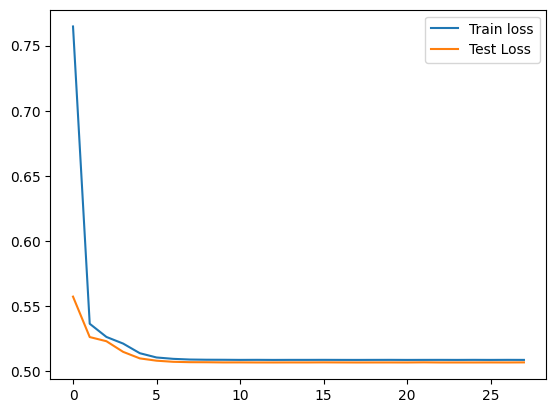

In [124]:
#Vizualizacion de la perdida
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [125]:
loss = model.evaluate(X_test, y_test)
loss

373/373 [==============================] - 1s 1ms/step - loss: 0.5069


0.5069113969802856

In [127]:
y_pred = model.predict(X_test)
y_pred_rounded = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_rounded)

accuracy

373/373 [==============================] - 1s 1ms/step


0.7822147651006711

Con respecto al anterior modelo donde se plantabla un porcentaje de perdida similar, el acurracy aumento, por lo que hacer un analisis usando la tecnica de disminucion de la dimensionalidad fue de mucha ayuda al momento de evaluar posibles modelos.

# **Conclusiones Generales**

Segun la informacion recopilada, los dos modelos vistos en el pryecto funcionan muy bien para saber que tipo de recalada llega a un determinado puerto. 

La experiencia nos dice que segun las caracteristicas del puerto, este puede ser denoominado un homeport o simplememte un puerto de barcos en transito, por lo que predecir el tipo de recalada no deberia ser muy dificil en primera estancia, sin embargo, cuando se agregan factores externos (haciendo referencia a cualquier factor que pueda afectar el itinerario o navegacion de un barco), estas circustancias pueden cambiar. 

Durante el desarrollo del proyecto, nos arrojo buenas metricas por parte de los dos modelos de clasificacion usados. Sin embargo, con el ejercicio de redes neuronales junto al analisis PCA, pudimos mejorar estas metricas si tenemos en cuenta que la reduccion de la dimensionalidad de los datos y el entrenamiento no supervisado del modelo fueron factores fundamentales para eliminar el "ruido" que generan las columnas agregadas por el One hot. 